Please enter the cardinality (no. of stocks) for portfolio :  12
Enter the number of large-cap stocks to select:  6
Enter the number of mid-cap stocks to select:  3
Enter the total budget limit for portfolio :  30000
Enter upper budget limit for each stock (e.g., 0.20 for 20%):  0.25
Enter lower budget limit for each stock (e.g., 0.05 for 5%):  0.06
Enter the weight for fitness score (e.g., 0.5):  0.3
Enter the weight for percent change (e.g., 0.2):  0.1
Enter the weight for revenue growth (e.g., 0.25):  0.55
Enter the weight for normalized budget (e.g., 0.05):  0.05


Run 1/1...
Epoch 0, Best Fitness: 6.188818265036236
Epoch 100, Best Fitness: 6.824310271089556
Epoch 200, Best Fitness: 7.013707407902614
Epoch 300, Best Fitness: 7.28389653498463
Epoch 400, Best Fitness: 7.28389653498463
Best Portfolio Found:
[5, 'NVDA', 'NVIDIA', 480, 1, 4]
[60, 'HDB', 'HDFC Bank', 65, 1, 28]
[67, 'NOW', 'ServiceNow', 715, 1, 3]
[76, 'RY', 'Royal Bank of Canada', 95, 1, 19]
[85, 'SNY', 'Sanofi', 48, 1, 38]
[115, 'HES', 'Hess Corporation', 136, 2, 14]
[122, 'O', 'Realty Income', 56, 2, 33]
[179, 'NTRS', 'Northern Trust', 82, 3, 22]
[182, 'MGA', 'Magna International', 54, 3, 34]
[203, 'FI', 'Fiserv, Inc.', 151, 1, 12]
[285, 'MLM', 'Martin Marietta Materials, Inc.', 596, 2, 4]
[441, 'MSM', 'MSC Industrial Direct Co., Inc.', 99, 3, 19]
Total Budget Used: 22983.0
Normalised Total Budget Used: 0.77
Best Objective Function Value: 7.2907
Time taken by the SHLO algorithm: 495.50 seconds
[*********************100%%**********************]  1 of 1 completed
[********************

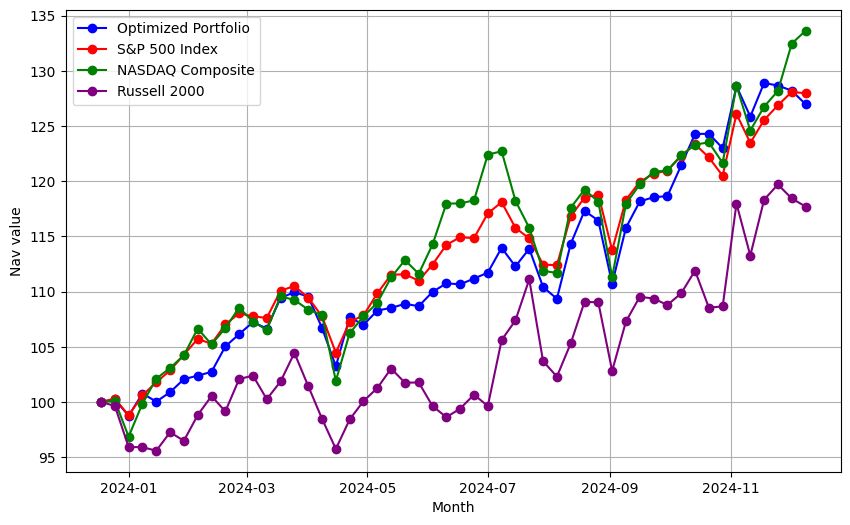

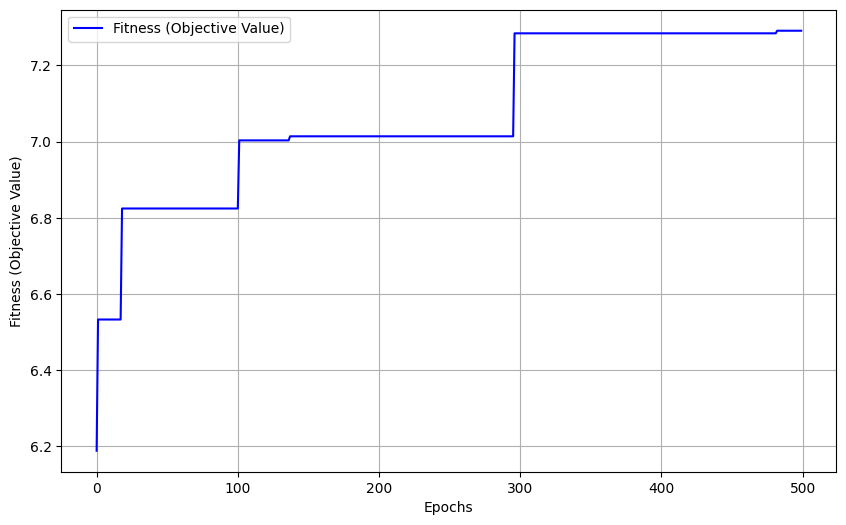

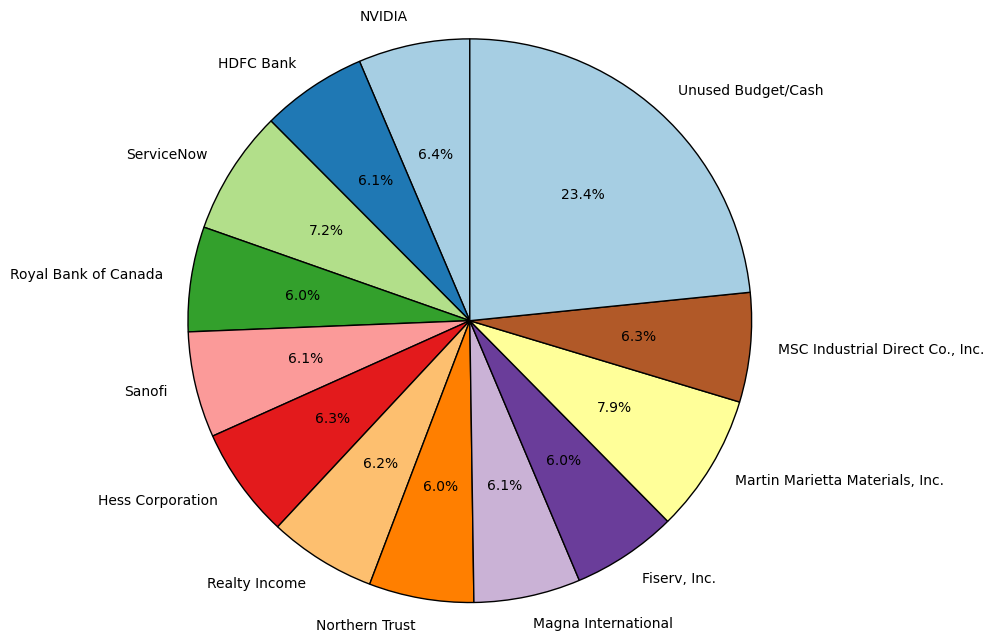

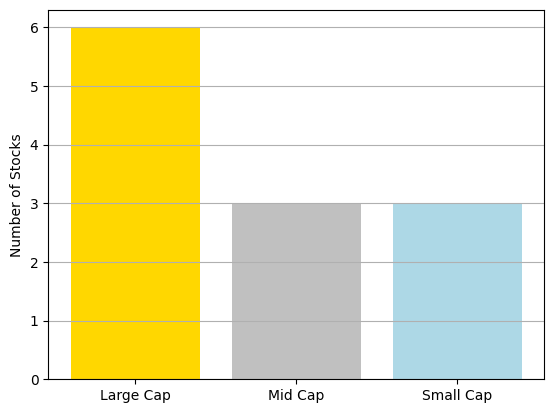

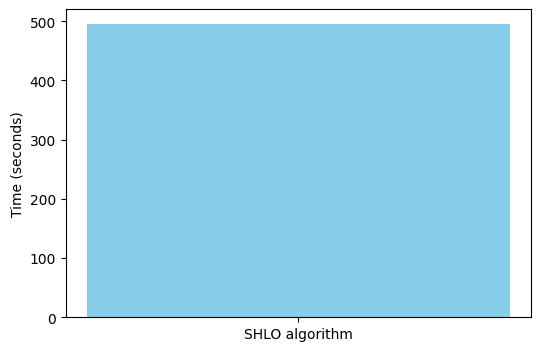

In [5]:
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
import seaborn as sb
import yfinance as yf
import datetime

#Constants
EPOCHS = 500
POP_SIZE = 100

PORTFOLIO_SIZE = int(input("Please enter the cardinality (no. of stocks) for portfolio : "))

# Global variables
stocks = pd.DataFrame()
skd = [[] for _ in range(10)]  # Social Knowledge Database

class Node:
    def __init__(self, solution=None):
        self.sol = solution if solution is not None else []
        self.fitness = 0
        self.ikd = [[] for _ in range(6)]  # Individual Knowledge Database

class BudgetAllocation:
    def __init__(self, total_budget, upper_budget_limit, lower_budget_limit):
        self.total_budget = total_budget
        self.upper_budget_limit = upper_budget_limit
        self.lower_budget_limit = lower_budget_limit

    def calculate_budget_allocation(self, stock_price, min_quantity, max_quantity):
        upper_budget = int(self.total_budget * self.upper_budget_limit)
        lower_budget = int(self.total_budget * self.lower_budget_limit)
        
        for quantity in range(min_quantity, max_quantity + 1):
            budget_used = stock_price * quantity
            if lower_budget <= budget_used <= upper_budget:
                return quantity, budget_used, self.total_budget - budget_used, True
        
        return None, None, None, False
        

def load_data(file_path):
    global stocks
    stocks = pd.read_csv(file_path)
    return len(stocks)

def initialize_population(num_stocks):
    population = [Node() for _ in range(POP_SIZE)]

    for node in population:
        node.sol = [0] * num_stocks
        selected_stocks = random.sample(range(num_stocks), PORTFOLIO_SIZE)
        for i in selected_stocks:
            node.sol[i] = 1
    return population

def initialize_knowledge_databases(population, num_stocks):
    for node in population:
        for k in range(1, 6):
            node.ikd[k] = [0] * num_stocks
            selected_stocks = random.sample(range(num_stocks), PORTFOLIO_SIZE)
            for i in selected_stocks:
                node.ikd[k][i] = 1

    for k in range(1, 10):
        skd[k] = [0] * num_stocks
        selected_stocks = random.sample(range(num_stocks), PORTFOLIO_SIZE)
        for i in selected_stocks:
            skd[k][i] = 1


# Function to ensure category constraint is respected
def check_category_constraint(selected_indices, stocks, large_cap_count, mid_cap_count, small_cap_count):
    large_cap = sum(1 for idx in selected_indices if stocks.iloc[idx]['Category'] == 1)
    mid_cap = sum(1 for idx in selected_indices if stocks.iloc[idx]['Category'] == 2)
    small_cap = sum(1 for idx in selected_indices if stocks.iloc[idx]['Category'] == 3)

    return large_cap == large_cap_count and mid_cap == mid_cap_count and small_cap == small_cap_count

# Check_constraints to ensure all constraints satisfied
def check_constraints(solution, budget_allocator, large_cap_count, mid_cap_count, small_cap_count):
    selected_indices = [i for i, x in enumerate(solution.sol) if x == 1]
    
    # Check if the selected stocks meet the portfolio size constraint
    if len(selected_indices) != PORTFOLIO_SIZE:
        return False

    # Check if the selected stocks meet the category constraint
    if not check_category_constraint(selected_indices, stocks, large_cap_count, mid_cap_count, small_cap_count):
        return False

    # Check if the selected stocks meet the budget constraint
    total_budget_used = 0
    for idx in selected_indices:
        stock = stocks.iloc[idx]
        _, budget_used, _, success = budget_allocator.calculate_budget_allocation(
            stock['Stock Price'], stock['Lower_limit'], stock['Upper_limit']
        )
        if not success:
            return False
        total_budget_used += budget_used

    # Ensure the total budget is not exceeded
    if total_budget_used > budget_allocator.total_budget:
        return False

    return True


def fitness(node, budget_allocator, normalized_total_budget, large_cap_count, mid_cap_count, small_cap_count, weight_fitness, weight_percent_change, weight_rev_growth, weight_normalized_budget):
    if not check_constraints(node, budget_allocator, large_cap_count, mid_cap_count, small_cap_count):
        return 0  # Return 0 fitness if constraints are not met

    # Use the already loaded 'stocks' data from the global variable
    global stocks

    # Initialize total fitness (objective function value)
    total_objective_function = 0

    # Get the selected stocks from the solution
    selected_indices = [i for i, x in enumerate(node.sol) if x == 1]

    for idx in selected_indices:
        stock = stocks.iloc[idx]  # Get the stock details from the global stocks DataFrame
        stock_id = stock['Stock_ID']

        # Extract the necessary values for the objective function from the global stocks data
        normalized_fitness_score = stock['normalized_fitness_score']
        normalized_percent_change = stock['normalized_percent_change_from_instrinsic_value']
        normalized_rev_growth = stock['normalized_Rev_Gr_Next_Y']

        # Calculate how many units of the stock can be bought
        quantity, budget_used, _, success = budget_allocator.calculate_budget_allocation(
            stock['Stock Price'], stock['Lower_limit'], stock['Upper_limit']
        )

        # Only calculate objective function if budget allocation is successful
        if success:
            # Calculate the objective function for the current stock
            objective_function_value = (
                weight_fitness * normalized_fitness_score +
                weight_percent_change * normalized_percent_change +
                weight_rev_growth * normalized_rev_growth +
                weight_normalized_budget * normalized_total_budget
            )

            total_objective_function += objective_function_value 

    return total_objective_function
    

def check_and_update_records(node, budget_allocator, large_cap_count, mid_cap_count, small_cap_count, weight_fitness, weight_percent_change, weight_rev_growth, weight_normalized_budget):
    
    # Calculate total budget used by the current node's portfolio
    portfolio, total_budget_used = format_portfolio(node, budget_allocator)
    # Calculate normalized total budget
    normalized_total_budget = total_budget_used / budget_allocator.total_budget
    
    # Update IKD
    min_fitness_ikd = min(fitness(Node(ikd), budget_allocator, normalized_total_budget, large_cap_count, mid_cap_count, small_cap_count, weight_fitness, weight_percent_change, weight_rev_growth, weight_normalized_budget) for ikd in node.ikd[1:])
    if node.fitness > min_fitness_ikd:
        min_index = min(range(1, 6), key=lambda i: fitness(Node(node.ikd[i]), budget_allocator, normalized_total_budget, large_cap_count, mid_cap_count, small_cap_count, weight_fitness, weight_percent_change, weight_rev_growth, weight_normalized_budget))
        node.ikd[min_index] = node.sol.copy()

    # Update SKD
    min_fitness_skd = min(fitness(Node(skd_sol), budget_allocator, normalized_total_budget, large_cap_count, mid_cap_count, small_cap_count, weight_fitness, weight_percent_change, weight_rev_growth, weight_normalized_budget) for skd_sol in skd[1:])
    if node.fitness > min_fitness_skd:
        min_index = min(range(1, 10), key=lambda i: fitness(Node(skd[i]), budget_allocator, normalized_total_budget, large_cap_count, mid_cap_count, small_cap_count, weight_fitness, weight_percent_change, weight_rev_growth, weight_normalized_budget))
        skd[min_index] = node.sol.copy()
        
        
def shlo_evolve(population, budget_allocator, large_cap_count, mid_cap_count, weight_fitness, weight_percent_change, weight_rev_growth, weight_normalized_budget, num_runs=1):
    small_cap_count = PORTFOLIO_SIZE - large_cap_count - mid_cap_count
    objective_values_over_iterations = []  # List to store objective values at each iteration
    all_runs_fitness = []  # To store fitness values from all runs

    for run in range(num_runs):
        print(f"Run {run + 1}/{num_runs}...")
        for epoch in range(EPOCHS):
            # Calculate the iteration ratio for dynamic probability adjustment
            iteration = epoch / EPOCHS
            probabilities = [0.4, 0.3, 0.3]  # Probabilities for [random, individual, social]
            perturbation_rate = max(0.2, 0.5 * (1 - iteration))  # Decay rate for randomness

            for node in population:
                original_sol = node.sol.copy()
                original_fitness = node.fitness

                for j in range(len(node.sol)):
                    rand_choice = random.random()

                    if rand_choice <= probabilities[0]:  # Random learning
                        if random.random() < perturbation_rate:
                            node.sol[j] = 1 - node.sol[j]  # Flip the bit (mutation)
                            
                    elif probabilities[0] < rand_choice <= (probabilities[0] + probabilities[1]):  # Hybrid learning
                        w1 = 1 - iteration  # Weight for individual learning
                        w2 = iteration      # Weight for social learning
                        ikd_value = node.ikd[random.randint(1, 5)][j]
                        skd_value = skd[random.randint(1, 9)][j]
                        node.sol[j] = ikd_value if w1 > random.random() else skd_value
 
                    else: 
                        node.sol[j] = skd[random.randint(1, 9)][j]  # Social learning
                        

        
                #Ensure exactly PORTFOLIO_SIZE stocks are selected
                while sum(node.sol) != PORTFOLIO_SIZE:
                    if sum(node.sol) > PORTFOLIO_SIZE:
                        indices = [i for i, x in enumerate(node.sol) if x == 1]
                        node.sol[random.choice(indices)] = 0
                    else:
                        indices = [i for i, x in enumerate(node.sol) if x == 0]
                        node.sol[random.choice(indices)] = 1

                # Check if the solution meets all constraints (budget, size, category)
                if not check_constraints(node, budget_allocator, large_cap_count, mid_cap_count, small_cap_count):
                    node.sol = original_sol  # Revert to original if constraints are not met
                    node.fitness = original_fitness
                else:
                    # Calculate the total budget used by the current solution
                    portfolio, total_budget_used = format_portfolio(node, budget_allocator)

                    # Calculate normalized total budget
                    normalized_total_budget = total_budget_used / budget_allocator.total_budget

                    # Calculate the new fitness and update if better
                    new_fitness = fitness(node, budget_allocator, normalized_total_budget, large_cap_count, mid_cap_count, small_cap_count, weight_fitness, weight_percent_change, weight_rev_growth, weight_normalized_budget)
                    if new_fitness > node.fitness:
                        node.fitness = new_fitness
                        check_and_update_records(node, budget_allocator, large_cap_count, mid_cap_count, small_cap_count, weight_fitness, weight_percent_change, weight_rev_growth, weight_normalized_budget)
                    else:
                        node.sol = original_sol
                        node.fitness = original_fitness

            # Sort population by fitness 
            population.sort(key=lambda x: x.fitness, reverse=True)
            # Store best fitness (objective value) at each epoch to the list
            objective_values_over_iterations.append(population[0].fitness)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Best Fitness: {population[0].fitness}")

        all_runs_fitness.append(objective_values_over_iterations)  # Store fitness history of the current run

    # Return the best solution (best Node) and the objective values over iterations
    return population[0], objective_values_over_iterations, all_runs_fitness


def format_portfolio(solution, budget_allocator):
    selected_indices = [i for i, x in enumerate(solution.sol) if x == 1]
    portfolio = []
    total_budget_used = 0
    for idx in selected_indices:
        stock = stocks.iloc[idx]
        quantity, budget_used, _, _ = budget_allocator.calculate_budget_allocation(
            stock['Stock Price'], stock['Lower_limit'], stock['Upper_limit']
        )
        total_budget_used += budget_used
        portfolio.append([
            stock['Stock_ID'],  # Using 'Stock_ID' instead of 'Index'
            stock['Symbol'],
            stock['Company Name'],
            stock['Stock Price'],
            stock['Category'],  # Added 'Category' to match your desired output
            quantity
        ])
    
    return portfolio, total_budget_used


def main():
   
    file_path = r"C:\Users\Code file SHLO\Final_Input_datasetcsv"
    num_stocks = load_data(file_path)

    # User input for category constraints (large-cap and mid-cap counts)
    large_cap_count = int(input("Enter the number of large-cap stocks to select: "))
    mid_cap_count = int(input("Enter the number of mid-cap stocks to select: "))
    
    # Total budget limit Constraints
    total_budget = int(input("Enter the total budget limit for portfolio : "))
    upper_budget_limit = float(input("Enter upper budget limit for each stock (e.g., 0.20 for 20%): "))
    lower_budget_limit = float(input("Enter lower budget limit for each stock (e.g., 0.05 for 5%): "))

    # Collect weights from the user input for parameter importance 
    weight_fitness = float(input("Enter the weight for fitness score (e.g., 0.5): "))
    weight_percent_change = float(input("Enter the weight for percent change (e.g., 0.2): "))
    weight_rev_growth = float(input("Enter the weight for revenue growth (e.g., 0.25): "))
    weight_normalized_budget = float(input("Enter the weight for normalized budget (e.g., 0.05): "))
    
    # Start timer before the optimization process begins
    start_time = time.time()

    
    # Create an instance of BudgetAllocation with user-provided budget limits
    budget_allocator = BudgetAllocation(total_budget, upper_budget_limit, lower_budget_limit)

    population = initialize_population(num_stocks)
    initialize_knowledge_databases(population, num_stocks)

    best_solution, objective_values_over_iterations, all_runs_fitness = shlo_evolve(population, budget_allocator, large_cap_count, mid_cap_count, weight_fitness, weight_percent_change, weight_rev_growth, weight_normalized_budget)

    portfolio, total_budget_used = format_portfolio(best_solution, budget_allocator)

    # End timer after the optimization process completes
    end_time = time.time()
    
    # Calculate the elapsed time
    time_taken = end_time - start_time


    print("Best Portfolio Found:")
    for stock in portfolio:
        print(f"[{stock[0]}, '{stock[1]}', '{stock[2]}', {stock[3]}, {stock[4]}, {stock[5]}]")
    
    print(f"Total Budget Used: {total_budget_used:.1f}")
    print(f"Normalised Total Budget Used: {total_budget_used / total_budget:.2f}")
    print(f"Best Objective Function Value: {best_solution.fitness:.4f}")
    # Print or log the time taken
    print(f"Time taken by the SHLO algorithm: {time_taken:.2f} seconds")


if __name__ == "__main__":
    main()